In this notebook, we run experiments with different locality sizes.

# Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math

# Importing our existing flow funcs
import os
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
# Import modules
from sine_funcs import generate_sine_wave, window_signal, compute_fft, analyze_fft_results
from analytic_flow_funcs import compute_linear_velocity_batch_time

# Set device (automatically detects GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Glue Functions

In [2]:
def denoise_samples(noise_samples, local_denoiser_dataset, num_steps, locality_sizes, dt, device='cuda', print_interval=10):
    num_samples, num_points = noise_samples.shape
    trajectories = torch.zeros(num_samples, num_steps + 1, num_points, device=device)
    trajectories[:, 0] = noise_samples.clone()
    
    # Denoising loop for each sample
    for sample_idx in range(num_noise_samples):
        current_points = noise_samples[sample_idx].clone()
        
        current_time = 0
        for step in range(1, num_steps + 1):
            # Get current time and locality size
            current_locality = locality_sizes[step - 1]
            local_denoiser_dataset.set_time(current_time)
            local_windows = local_denoiser_dataset.set_local_windows(current_locality)
            
            # Process current noise sample
            windows = current_points.unfold(0, current_locality, 1)
            local_velocities = local_denoiser_dataset.match_to_local(windows)
            
            # Accumulate velocities
            output = torch.zeros(num_points, device=device)
            count = torch.zeros(num_points, device=device)
            
            for i in range(windows.shape[0]):
                start = i
                end = i + current_locality
                output[start:end] += local_velocities[i]
                count[start:end] += 1
            
            net_velocity = output / count
            current_points = current_points + net_velocity * dt
            current_time += dt
            
            # Store in trajectories tensor
            trajectories[sample_idx, step] = current_points.clone()
        if sample_idx%print_interval == 0:
            print(f"Completed denoising for sample {sample_idx+1}/{num_noise_samples}")
    return trajectories

In [3]:
from matplotlib.animation import FuncAnimation

def multi_trajectory_animation(trajectories, interval=100, dataset=None, fig_width=8):
    """Creates vertical animation of 3 denoising trajectories.
    
    Args:
        trajectories: 3D tensor of shape (num_samples, time_steps, signal_length)
        interval: Delay between frames in milliseconds
        dataset: Optional target waveform for comparison
        fig_width: Width of the figure in inches
        
    Returns:
        matplotlib.animation.FuncAnimation object
    """
    # Convert to numpy and adjust dimensions
    if isinstance(trajectories, torch.Tensor):
        trajectories = trajectories.detach().cpu().numpy()
    
    # Transpose to (time_steps, num_samples, signal_length)
    trajectories = np.transpose(trajectories, (1, 0, 2))
    
    # Select first 4 samples (or all if less than 5)
    num_samples = min(4, trajectories.shape[1])
    selected_samples = trajectories[:, :num_samples, :]
    
    # Create figure with vertical subplots
    fig, axes = plt.subplots(num_samples, 1, figsize=(fig_width, 2*num_samples))
    if num_samples == 1:
        axes = [axes]  # Make iterable
    
    # Initialize lines
    lines = []
    for ax, sample_idx in zip(axes, range(num_samples)):
        line, = ax.plot([], [], 'b-', alpha=0.8, label='Denoising')
        lines.append(line)
        ax.set_xlim(0, selected_samples.shape[2])
        ax.set_ylim(selected_samples.min()-0.1, selected_samples.max()+0.1)
        ax.grid(True, alpha=0.3)
        ax.set_ylabel(f"Sample {sample_idx+1}")
        
        # Plot target if provided
        if dataset is not None:
            target = dataset[0].cpu().numpy() if isinstance(dataset, torch.Tensor) else dataset
            ax.plot(target, 'r--', alpha=0.5, label='Dataset Example')
            if sample_idx == 0:
                ax.legend(loc='upper right')
    
    # Set common xlabel at bottom
    axes[-1].set_xlabel("Position")
    
    def update(frame):
        for sample_idx, line in enumerate(lines):
            line.set_data(np.arange(selected_samples.shape[2]), 
                         selected_samples[frame, sample_idx])
        return lines
    
    anim = FuncAnimation(fig, update, frames=selected_samples.shape[0],
                       interval=interval, blit=True)
    plt.close()
    return anim

# Local Sine Wave Class

A class to quickly generate local sine datasets.

In [4]:
class Local_Sine_Wave_Denoiser:
    def __init__(self, original_data: torch.Tensor, sigma_i: float, device = "cpu"):
        """
            original_data: Tensor of shape [B, N] where B is batch, N is points
        """
        self.original_data = original_data.clone()
        self.sigma_i = sigma_i
        self.device = device

    def set_time(self, new_time: float) -> None:
        """Set a new time value"""
        self.current_time = new_time
    
    def set_local_windows(self, window_size: int, stride = None) -> torch.Tensor:
        """
        Generates windowed view of the current data
            window_size: Size of each window
            stride: Step between windows (default 1)
        Returns:
            Windowed tensor of shape [B * num_windows, window_size], num_windows = (B - window_size) / stride
        """
        if stride is None:
            stride = 1
        # Apply unfolding to each batch element
        windows = [signal.unfold(0, window_size, stride) 
                  for signal in self.original_data]
        
        self.local_data = torch.cat(windows, dim=0).to(self.device)
        return self.local_data

    def match_to_local(self, current_pts_windowed, print_checks = False) -> torch.Tensor:
        # Takes in a tensor with batches [B, N], where N is the size of local windows
        # Create time tensor matching input batch dimension, generates the flow-matching velocities.
        
        M = current_pts_windowed.shape[0]  # Input batch dimension
        time_tensor = torch.full((M,), self.current_time, device=self.device)
        if (print_checks):
            print("\n=== Tensor Check ===")
            print(f"current_pts_windowed: {current_pts_windowed.device} (shape: {current_pts_windowed.shape})")
            print(f"self.local_data: {self.local_data.device} (shape: {self.local_data.shape})")
            print(f"time_tensor: {time_tensor.device} (shape: {time_tensor.shape})")
            print(f"self.sigma_i: {type(self.sigma_i)} (scalar value: {self.sigma_i})")
            print("===================\n")
            
        # Compute velocity
        velocity = compute_linear_velocity_batch_time(
            current_pts_windowed, 
            self.local_data, 
            time_tensor, 
            self.sigma_i)
        return velocity


## Data and Noise Generation

In [5]:
# Function to create a dataset of sine waves of different phases
# Takes in a list of phases, the width of the dataset, and the frequency
# Create a tensor of shape [B, W] where B is number of phases, W is num_points
def create_phase_dataset(phases, num_points=1000, points_per_cycle=40, device = 'cpu'):
    dataset = torch.stack([generate_sine_wave(num_points, points_per_cycle, phase_offset=phase, device = device)
        for phase in phases])
    return dataset

# Dataset generation
num_points = 100 #points in a sample
points_per_cycle = 20
phases = [0]#, math.pi]#/4, math.pi/2, 3*math.pi/4]  # Example phase offsets
dataset = create_phase_dataset(phases, num_points, points_per_cycle, device = device)

# Load our dataset into an instance of local_sine_wave
local_denoiser_dataset = Local_Sine_Wave_Denoiser(dataset, sigma_i = 1.0, device = device)

In [6]:
# Noise Parameters
num_noise_samples = 50  # Number of different noise samples to process
noise_samples = torch.randn(size=(num_noise_samples, num_points), device=device)

In [7]:
# Denoising Parameters
num_steps = 10         # Number of denoising steps
dt = 1.0 / num_steps
local_size = num_points

# Shape: [num_noise_samples, num_steps+1, num_points]
locality_sizes = torch.full((num_steps,), local_size, device=device) #for each step, use a local window of 100 points.

## Denoising

In [8]:
trajectories = denoise_samples(
    noise_samples=noise_samples,
    local_denoiser_dataset=local_denoiser_dataset,
    num_steps=10,
    locality_sizes=locality_sizes,  # Constant window size
    dt=dt,
    device='cuda'
)

Completed denoising for sample 1/50
Completed denoising for sample 11/50
Completed denoising for sample 21/50
Completed denoising for sample 31/50
Completed denoising for sample 41/50


In [9]:
anim = multi_trajectory_animation(trajectories, dataset=dataset)

# To display in Jupyter notebook:
from IPython.display import HTML
HTML(anim.to_jshtml())

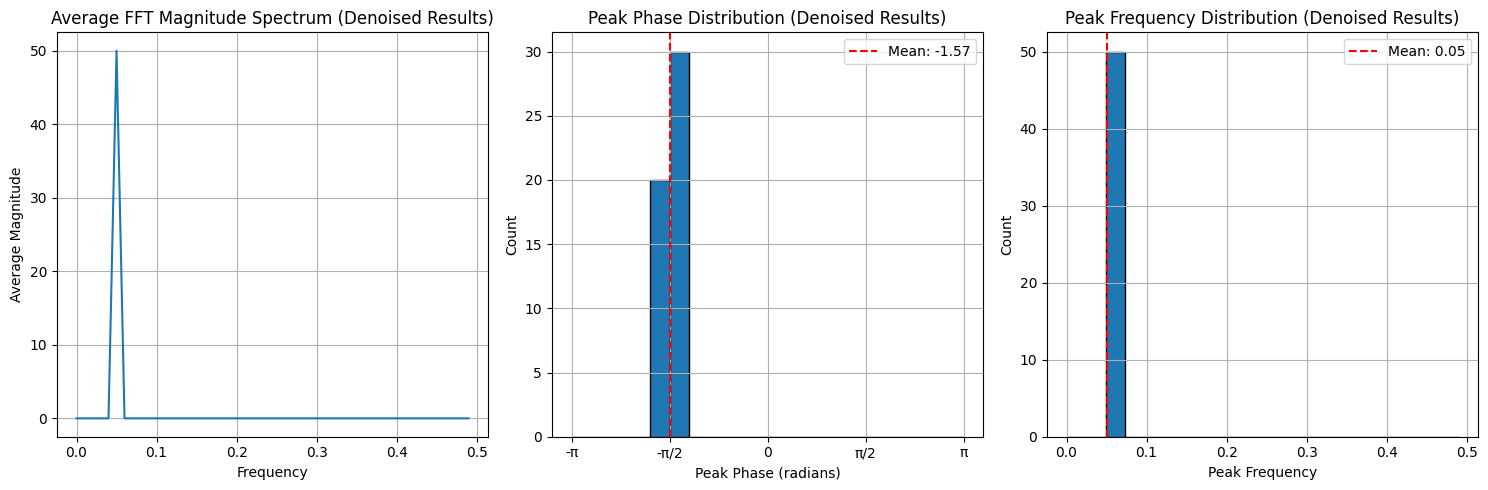


FFT Analysis Summary (50 samples):
Average peak phase: -1.571 ± 0.000 rad
Average peak frequency: 0.050 ± 0.000


In [10]:
analyze_fft_results(trajectories[:, -1, :], title_suffix="(Denoised Results)")

## Multiple Frequencies

In [11]:
# Dataset generation
num_points = 100 #points in a sample
points_per_cycle = 20
phases = [0, math.pi/4, math.pi/2, 3*math.pi/4]  # Example phase offsets
dataset = create_phase_dataset(phases, num_points, points_per_cycle, device = device)

# Load our dataset into an instance of local_sine_wave
local_denoiser_dataset = Local_Sine_Wave_Denoiser(dataset, sigma_i = 1.0, device = device)

In [12]:
trajectories = denoise_samples(
    noise_samples=noise_samples,
    local_denoiser_dataset=local_denoiser_dataset,
    num_steps=10,
    locality_sizes=locality_sizes,  # Constant window size
    dt=dt,
    device='cuda'
)

Completed denoising for sample 1/50
Completed denoising for sample 11/50
Completed denoising for sample 21/50
Completed denoising for sample 31/50
Completed denoising for sample 41/50


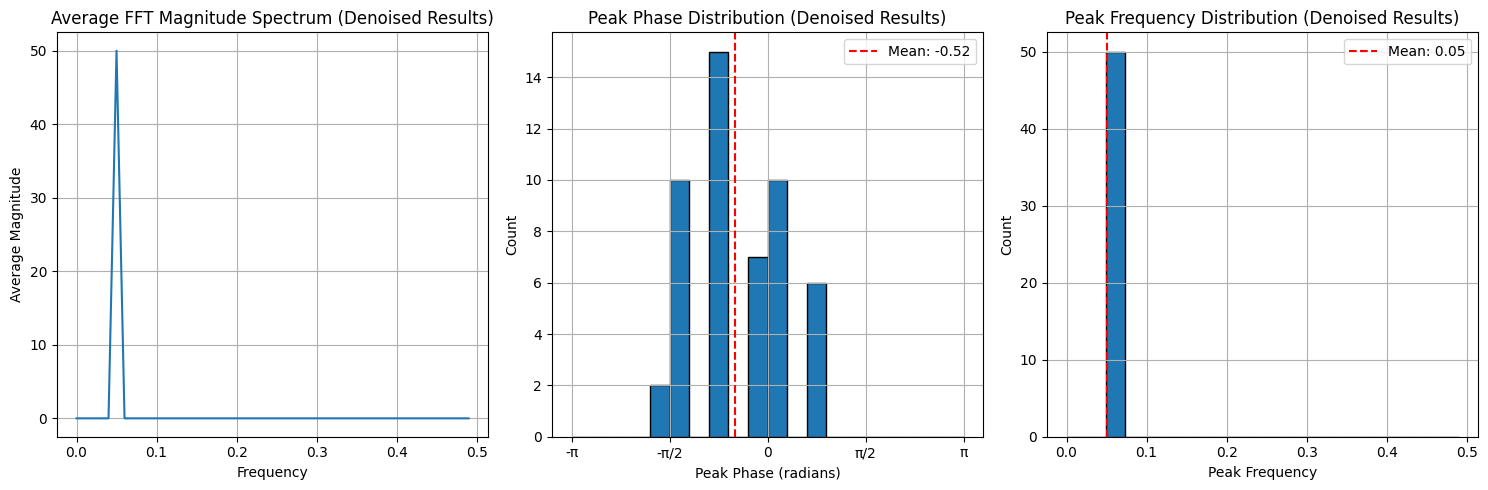


FFT Analysis Summary (50 samples):
Average peak phase: -0.518 ± 0.763 rad
Average peak frequency: 0.050 ± 0.000


In [13]:
analyze_fft_results(trajectories[:, -1, :], title_suffix="(Denoised Results)")
anim = multi_trajectory_animation(trajectories, dataset=dataset)

# To display in Jupyter notebook:
from IPython.display import HTML
HTML(anim.to_jshtml())